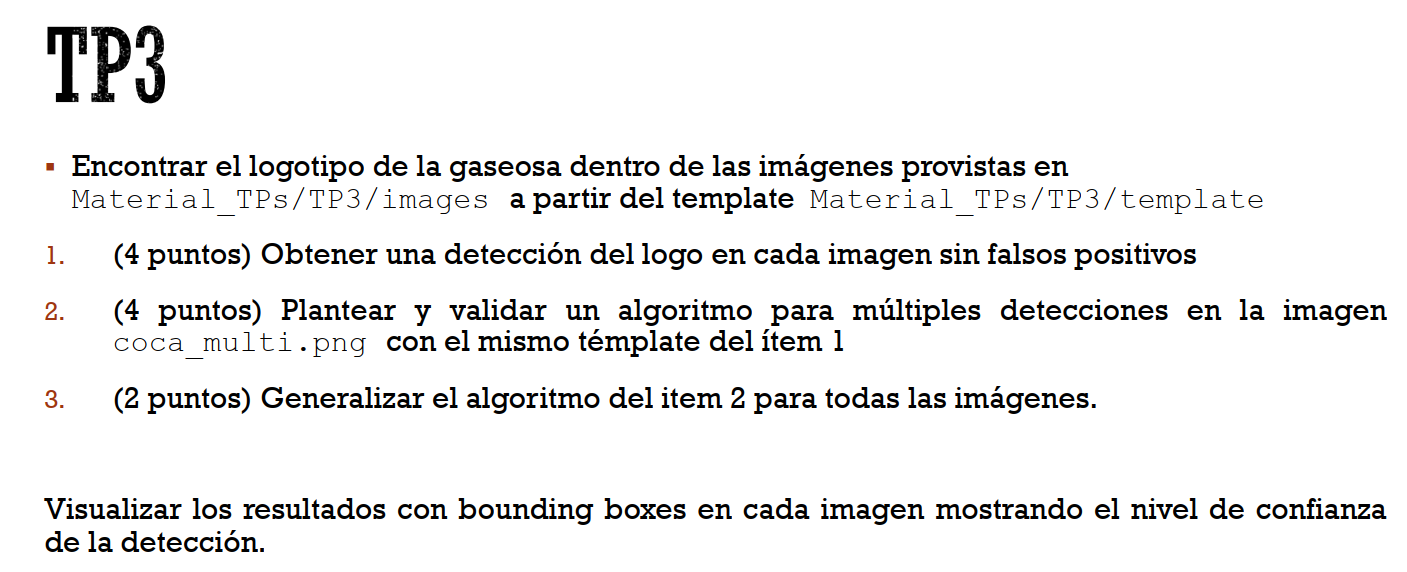

In [192]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline
#%matplotlib

import numpy as np
import cv2 as cv
import cv2
import math
import matplotlib.pyplot as plt
import os

## ---------------------------------- PARTE 1 ----------------------------------

Nombre: COCA-COLA-LOGO.jpg


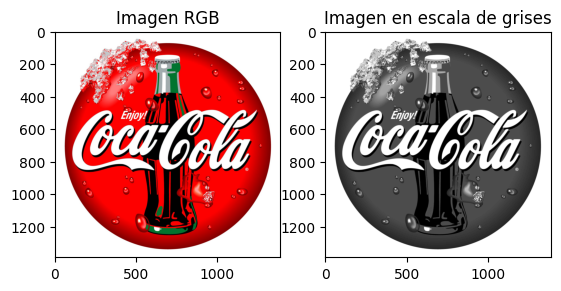

Nombre: coca_logo_1.png


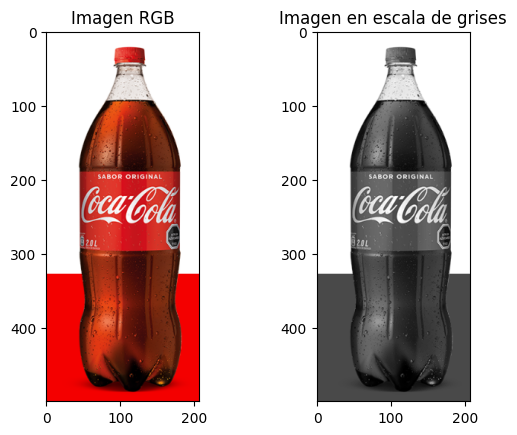

Nombre: coca_logo_2.png


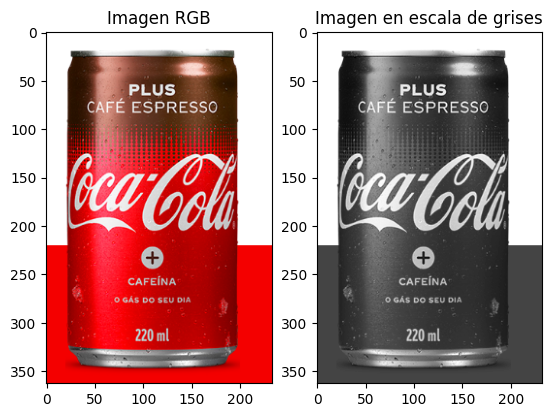

Nombre: coca_multi.png


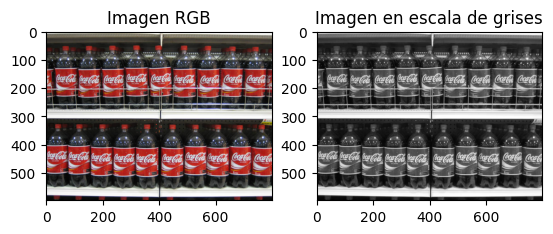

Nombre: coca_retro_1.png


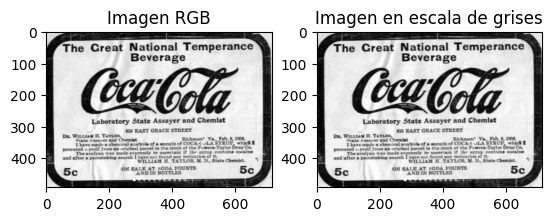

Nombre: coca_retro_2.png


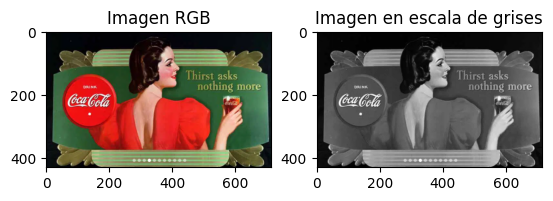

Nombre: logo_1.png


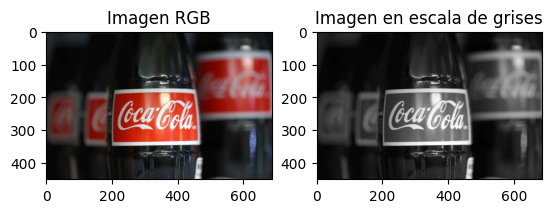

In [193]:
# Carga de las imagenes a procesar

# Ruta de la carpeta de imágenes
folder_path = './images/'  # Ajusta la ruta según la ubicación de tu carpeta

# Lista para almacenar la información de las imágenes
images_info = []

# Recorre los archivos en la carpeta de imágenes
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filtra solo archivos de imagen
        # Lee la imagen
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        if img is not None:
            # Convierte la imagen a RGB y escala de grises
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Guarda la información en un diccionario
            image_data = {
                'nombre': filename,
                'imagen_rgb': img_rgb,
                'imagen_gris': img_gray
            }

            # Agrega el diccionario a la lista
            images_info.append(image_data)

# Acceder a la información de las imágenes cargadas
for image_data in images_info:
    print(f"Nombre: {image_data['nombre']}")
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_data['imagen_rgb'])
    plt.title('Imagen RGB')
    plt.subplot(1, 2, 2)
    plt.imshow(image_data['imagen_gris'], cmap='gray')
    plt.title('Imagen en escala de grises')
    plt.show()


Text(0.5, 1.0, 'Template')

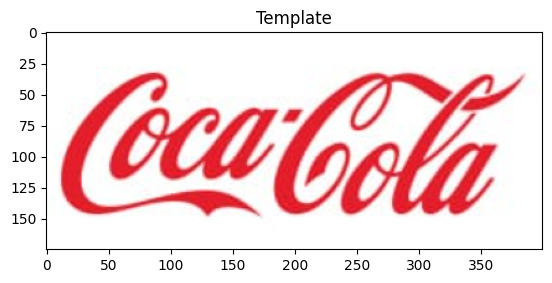

In [194]:
# Carga del template
template = cv.imread('.\\template\\pattern.png')
template_rgb = cv.cvtColor(template, cv.COLOR_BGR2RGB)
template_gray = cv.cvtColor(template, cv2.COLOR_BGR2GRAY)

# Visualizar imagenes y template
plt.figure()
plt.imshow(template_rgb, cmap='gray')
plt.title("Template")


Método de detección del logo

In [306]:
print('template: ', template.shape)
print('template_gray: ', template_gray.shape)
print('template_gray.shape[::-1] ', template_gray.shape[::-1] )

template:  (175, 400, 3)
template_gray:  (175, 400)
template_gray.shape[::-1]  (400, 175)


----------------------
top_left:  (48, 450)
bottom_right:  (148, 494)


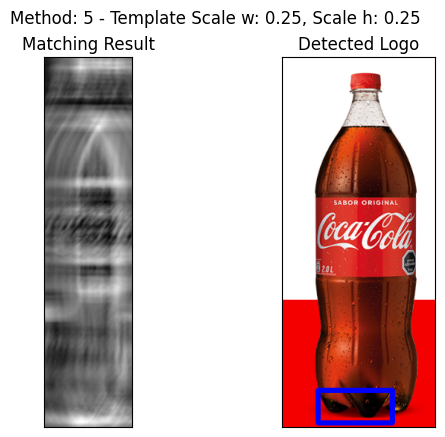

----------------------
top_left:  (82, 412)
bottom_right:  (182, 500)


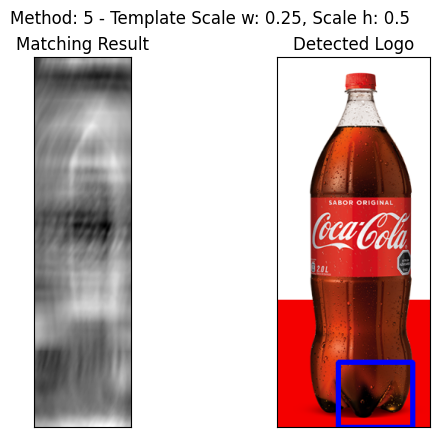

----------------------
top_left:  (55, 78)
bottom_right:  (155, 209)


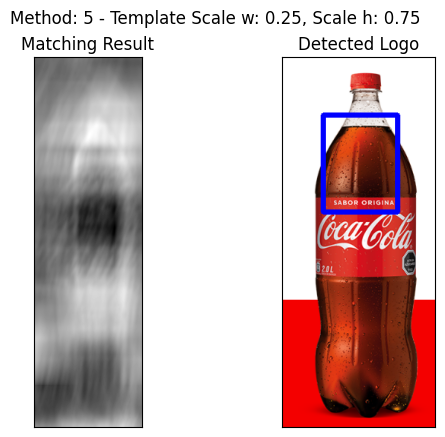

----------------------
top_left:  (54, 69)
bottom_right:  (154, 244)


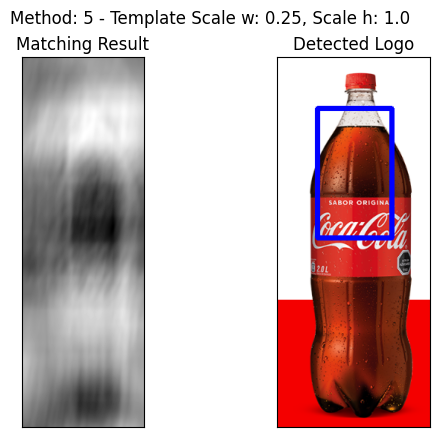

----------------------
top_left:  (89, 40)
bottom_right:  (189, 259)


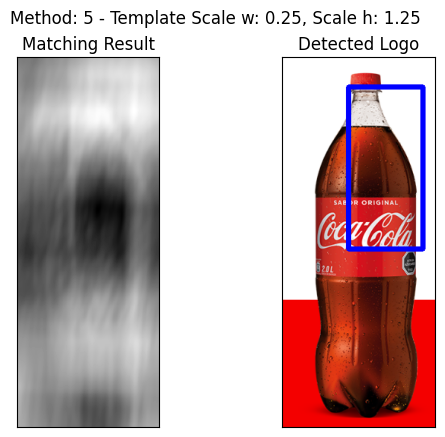

----------------------
top_left:  (89, 1)
bottom_right:  (189, 263)


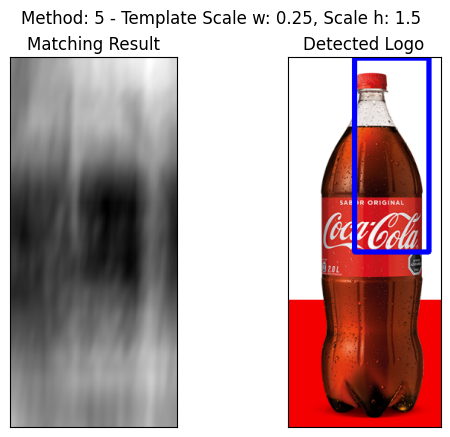

----------------------
top_left:  (89, 0)
bottom_right:  (189, 306)


In [321]:
w, h = template_gray.shape[::-1]

# eleccion de la imagen a procesar
imagen = 1

# Definimos el método para la detección
method = eval('cv.TM_CCOEFF_NORMED')  # Usamos cv.TM_CCOEFF como ejemplo

# Imagen en escala de grises de la imagen a procesar
img_gray = images_info[imagen]['imagen_gris']

# Iteramos sobre diferentes tamaños de la plantilla (mayores y menores)
for scale_w in range(1, 12, 1): #in [ 0.25, 0.5, 1, 2, 3, 4, 5]:  # Escala en el eje x
    scale_w = scale_w*0.25

    for scale_h in range(1, 12, 1):  # Escala en el eje y
        scale_h = scale_h*0.25

        # Re-escalado de del template
        scaled_w = int(w*scale_w)
        scaled_h = int(h*scale_h)
        template_scale = cv.resize(template_gray, None, fx=scale_w, fy=scale_h)
        # Si el tamaño de la plantilla es mayor que la imagen, dejamos de iterar
        if template_scale.shape[0] > img_gray.shape[0] or template_scale.shape[1] > img_gray.shape[1]:
           print("el tamaño de la plantilla es mayor que la imagen")
           break
        
        # Copia de la imagen
        img_salida = images_info[imagen]['imagen_rgb'].copy()

        # Aplicamos el template matching con la plantilla redimensionada
        res = cv.matchTemplate(img_gray, template_scale, method)

        # Encontramos los valores máximos y mínimos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
        if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
            top_left = min_loc 
        else:
            top_left = max_loc

        # Marcamos el lugar donde se encontró la coincidencia
        bottom_right = (top_left[0] + template_scale.shape[1], top_left[1] + template_scale.shape[0])
        # bottom_right = (
        #     top_left[0] + scaled_w , 
        #     top_left[1] + scaled_h
        #     )
    
        # print("imagen.shape: ", img_gray.shape)
        # print("template_scale.shape: ", template_scale.shape)
        # print("----------------------")
        # print("scaled_w: ",  scaled_w)
        # print("scaled_h: ",  scaled_h) 
        # print("----------------------")
        # print("top_left[0] + w*scale_w: ",  top_left[0] + scaled_w)
        # print("top_left[1] + h*scale_h: ",  top_left[1] + h*scale_h)
        # print("top_left[0]: ", type(top_left[0]))
        # print("top_left[1]: ", type(top_left[1]))
        print("----------------------")
        print("top_left: " ,  top_left)
        print("bottom_right: " ,  bottom_right)

        cv.rectangle(img_salida, 
                     top_left, 
                     bottom_right, 
                     (0, 0, 255), 
                     6)

        # Muestra el procesamiento para cada escala de la plantilla
        plt.figure()
        plt.subplot(121), plt.imshow(res, cmap='gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

        plt.subplot(122), plt.imshow(img_salida)
        plt.title('Detected Logo'), plt.xticks([]), plt.yticks([])

        plt.suptitle(f"Method: {method} - Template Scale w: {scale_w}, Scale h: {scale_h}")

        plt.show()
